# Animación EANA

Genera un video para un dia de vuelos de cabotaje en la Republica Argentina

## Inicialización

### Imports iniciales

In [101]:
#Imports iniciales

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import os
import seaborn as sns
from unidecode import unidecode 
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

### Carga de datos

In [112]:
#Carga de datos
eana = pd.read_csv('./input/eana1.csv',sep=';',encoding='latin1')
airports = pd.read_csv('./input/airports.csv', encoding='utf8')
provincias = pd.read_csv('./input/region_provincia.csv',encoding='utf8')

#parseo la fecha
eana['fecha_parseada'] = pd.to_datetime(eana['Fecha']+eana['Hora Movimiento HHMM'],format='%d/%m/%Y%H:%M')

#agrego columna anio y mes
eana['anio'] = eana.fecha_parseada.dt.year
eana['mes'] = eana.fecha_parseada.dt.month

#normalizo columnas de eana.
eana.columns = eana.columns.map(unidecode).str.lower().str.replace(' ','_')

## Animación
### Funciones auxiliares

In [113]:
from scipy import interpolate

def posicion_vuelo (coord_d, coord_a, t_d, t_a, t, smoothing=False):
    """ Interpola un vuelo dado su despegue y aterrizaje
    
    Args:
        coord_d (tuple): Coordenadas del despegue.
        coord_a (tuple): Coordenadas del aterrizaje.
        t_d (datetime): Tiempo de despegue.
        t_a (datetime): Tiempo de aterrizaje. 
        t (datetime array): Vector de tiempos a interpolar

    Returns:
        np.Array: Coordenadas intermedias del vuelo.
    """
    x_i = np.empty(len(t))
    x_i.fill(np.nan)
    y_i = np.empty(len(t))
    y_i.fill(np.nan)
    
    x_d, y_d = coord_d
    x_a, y_a = coord_a
    
    t_d = (t_d - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1,'s')
    t_a = (t_a - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1,'s')
    t = (t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1,'s')
    
    gi = (t > t_d) & (t < t_a)
    try: 
        # Agrego un ease-in ease-out sigmoideo, para la velocidad del avion
        if smoothing:
            alpha = 2./(t_a - t_d)
            t_gi = t[gi].astype(float)
            t_mitad = t[np.round((np.flatnonzero(gi)[0] + np.flatnonzero(gi)[-1])/2)]
            t_falso = 1/(1 + np.exp(-alpha * (t_gi - t_mitad)))
            delta_falso = np.max(t_falso) - np.min(t_falso)
            delta_real = t_a - t_d
            t_falso = (t_falso - np.min(t_falso)) / delta_falso * delta_real + t_d
        else:
            t_falso = t[gi]
        x_i[gi] = np.interp(t_falso, [t_d, t_a], [x_d, x_a])
        y_i[gi] = np.interp(t_falso, [t_d, t_a], [y_d, y_a])
    except TypeError:
        pass
    return [x_i, y_i]


def encontrar_aterrizaje(row , eana):
    """ Encuentra un registro de aterrizaje dado un despegue.
    
    Args:
        row (pd.Series): Datos del despegue.s
        eana (pd.DataFrame): Tabla en la que buscar.

    Returns:
        pd.Series: Fila correspondiente al aterrizaje.
    """
    if 'Aterrizaje' in row.tipo_de_movimiento:
        print 'Error: Es un aterrizaje.'
        return
    
    es_aterrizaje = eana.tipo_de_movimiento == 'Aterrizaje'
    coincide_avion = eana.aeronave == row.aeronave
    coincide_aerolinea = eana.aerolinea_nombre == row.aerolinea_nombre
    coincide_aeropuerto = (eana.origen_oaci == row.origen_oaci) & (eana.destino_oaci == row.destino_oaci)
    
    
    temp = eana[coincide_avion & coincide_aerolinea & coincide_aeropuerto & es_aterrizaje]
    temp.loc[:,'dt_diff'] = temp.fecha_parseada.values - np.datetime64(row.fecha_parseada)
    gi = temp.fecha_parseada.values < np.datetime64(row.fecha_parseada)
    temp.loc[gi,'dt_diff'] = np.timedelta64(5,'D')
    
    minimo = temp.dt_diff.idxmin()
    
    return temp.loc[minimo]


In [144]:
# Interpolo las posiciones para todo un vuelo
def interpolar_posiciones(fecha_inicio , fecha_fin, registros, extremos_coordenadas):
    """ Genera las posiciones de un vuelo dado  un registro de aterrizaje dado un despegue.
    
    Args:
        fecha_inicio (datetime): fecha de inicio para la animación
        fecha_fin (datetime): fecha de fin de para la animación
        registros (pd.DataFrame): Tabla en la que buscar
        extremos_coordenadas (pd.DataFrame): Tabla con las coordenadas de los aeropuertos.

    Returns:
        np.Array (tuple): Vectores con las coordenadas a graficar.
    """
    times = np.arange(FECHA_INICIO, FECHA_FIN, dtype='datetime64[m]', step=3)

    x = []
    y = []
    counter = 0
    print("Registros totales %d" % len(registros))
    for idx, row in registros.iterrows():
        counter += 1
        if counter % 100 == 0:  
            print '\rVa {0:.2f} %'.format(float(counter)/len(registros)*100),

        if 'Aterrizaje' in row.tipo_de_movimiento:
            continue

        coord_d = extremos_coordenadas[extremos_coordenadas.ident.str.contains(row.origen_oaci)][['longitude_deg','latitude_deg']].values.squeeze()
        coord_a = extremos_coordenadas[extremos_coordenadas.ident.str.contains(row.destino_oaci)][['longitude_deg','latitude_deg']].values.squeeze()

        t_d = row.fecha_parseada
        try:
            t_a = encontrar_aterrizaje( row, registros).fecha_parseada
            coord_i = posicion_vuelo (coord_d, coord_a, t_d, t_a, times, smoothing=True)
            coord_i_x, coord_i_y = coord_i  
            x.append(coord_i_x)
            y.append(coord_i_y)
        except:
            pass
        
    return x, y


### Restringir los datos a un rango de fechas particular

In [114]:
FECHA_INICIO = '2017-08-21'
FECHA_FIN = '2017-08-22'

vuelo_es_cabotaje = eana.clasificacion_vuelo.str.contains('Cabotaje')
vuelo_es_regular = eana.clase_de_vuelo.str.contains('Regular')
vuelo_en_fecha = (eana.fecha_parseada >= FECHA_INICIO) & (eana.fecha_parseada <= FECHA_FIN)

eana_temp = eana[vuelo_es_cabotaje & vuelo_es_regular & vuelo_en_fecha]

### Interpolar todos los vuelos del rango horario

Tarda ~ 1.6 minutos

In [145]:
%timeit -r 1 -n 1 x, y = interpolar_posiciones(FECHA_INICIO , FECHA_FIN, eana_temp, airports);

Registros totales 830


/home/melik/anaconda/envs/cleaner/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/melik/anaconda/envs/cleaner/lib/python2.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/melik/anaconda/envs/cleaner/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/melik/anaconda/envs/cleaner/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


Va 96.39 %       1 loop, best of 1: 1min 41s per loop



### Generar la Animacion

Tarda ~ 1 minuto

1 loop, best of 1: 51.2 ms per loop
1 loop, best of 1: 52.2 s per loop


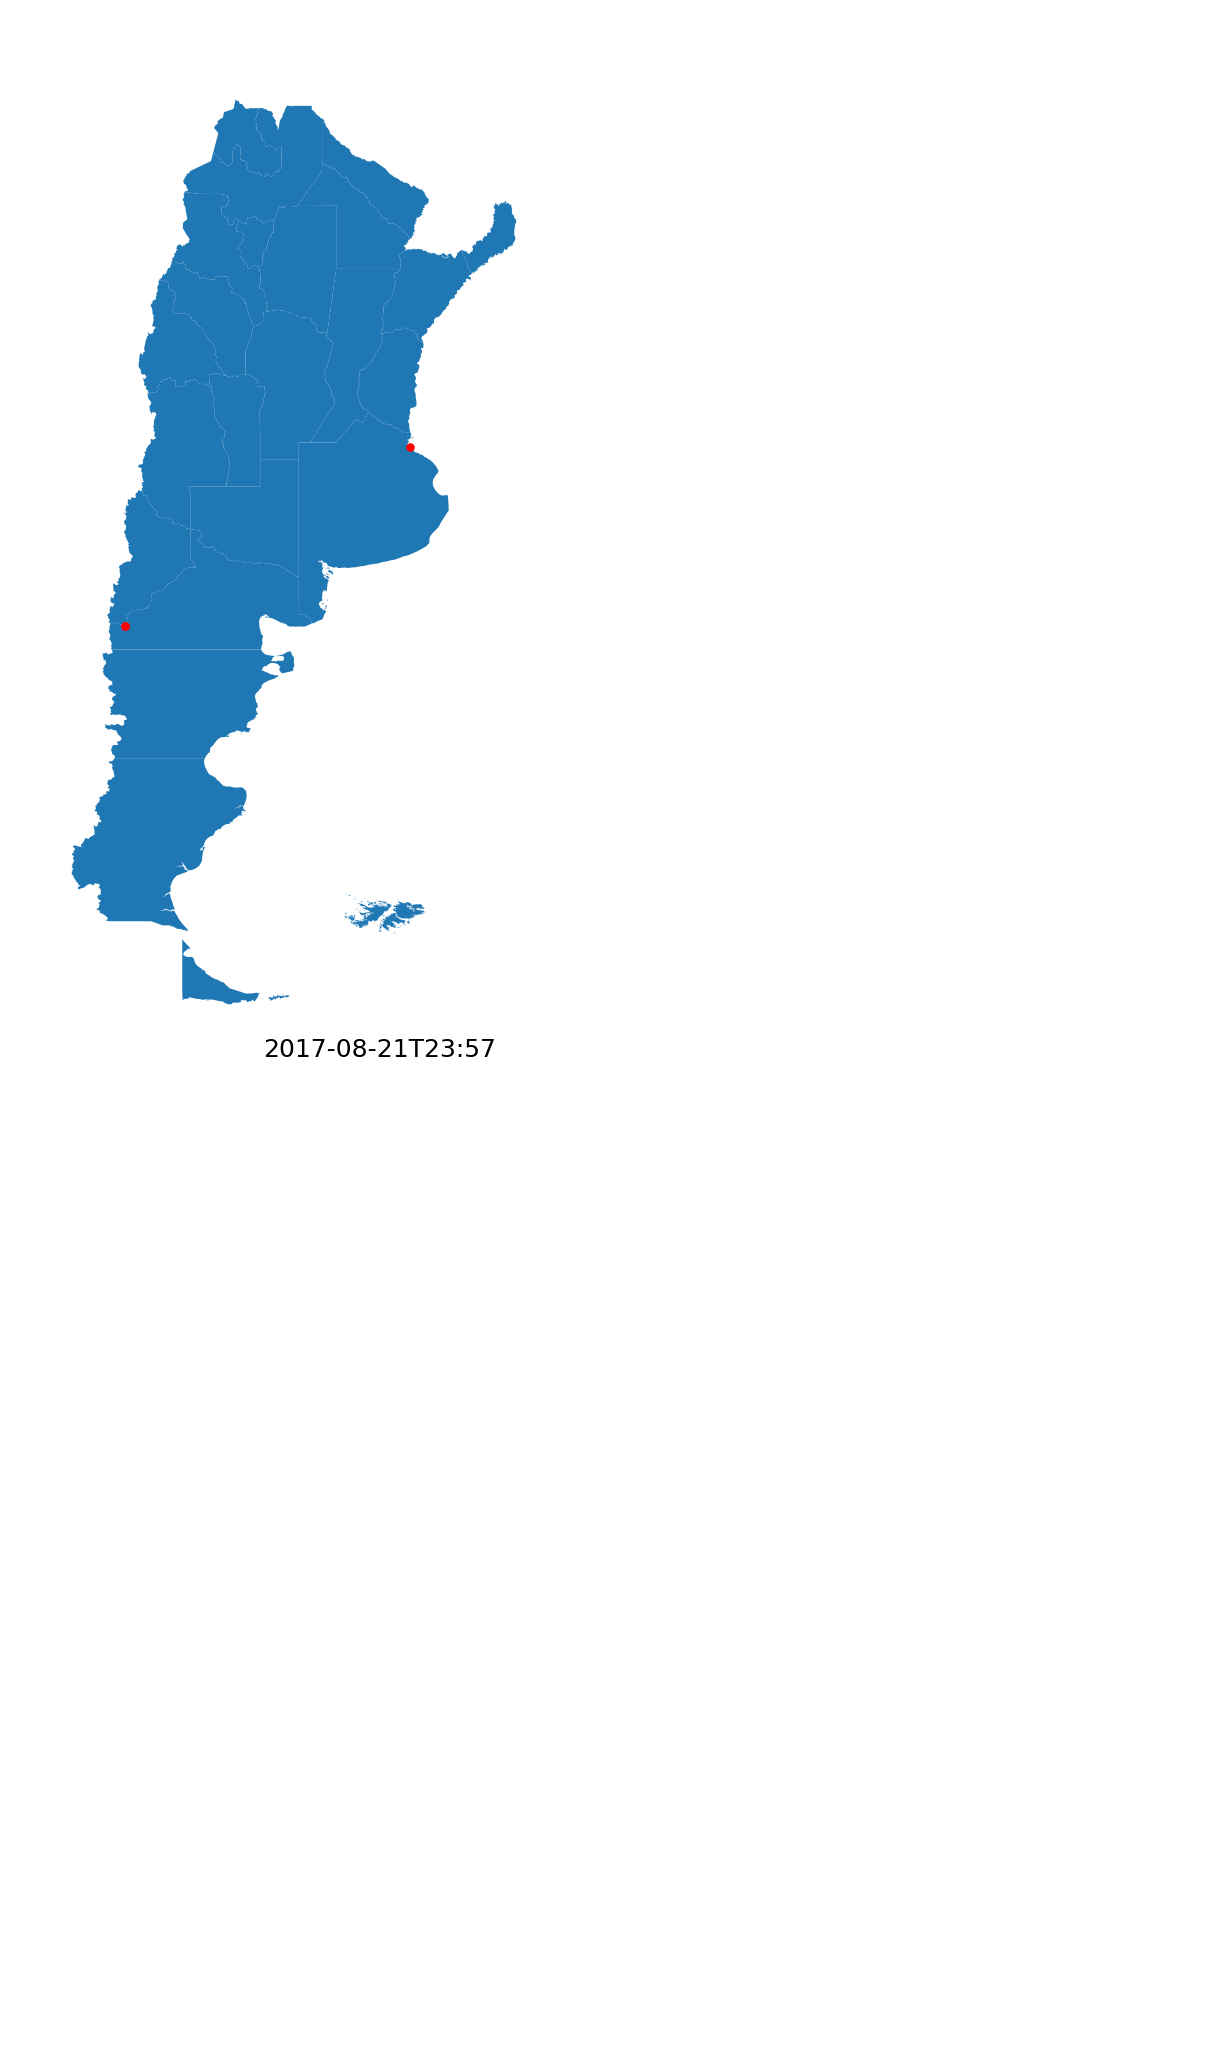

In [149]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,20))
ax_arg = fig.add_subplot(1,1,1)

# mundo = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# mundo[mundo.iso_a3=='ARG'].plot(ax=ax_arg); 
# Uso el mapa de mundo para pruebas porque es más liviano
# IMPORTANTE! Para el video usar ESTE: 
argentina = gpd.read_file('./input/provincia')
argentina.plot(ax=ax_arg);

point, = ax_arg.plot([], [], '.', color='red', markersize=15)
time_text = ax_arg.text(-65,-57, '', fontsize=25)
plt.xlim(-75,-50)
plt.ylim(-60,-20)
X = np.vstack(x).T
Y = np.vstack(y).T

plt.box('off')
plt.xticks([])
plt.yticks([])

# initialization function: plot the background of each frame
def init():
    point.set_data([], [])
    time_text.set_text('')

    return point, time_text

# animation function.  This is called sequentially
def animate(i):
    point.set_data(X[i], Y[i])
    time_text.set_text(str(times[i]))
    return point, time_text

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=480, interval=500, blit=True)

%timeit -r 1 -n 1 anim.save('./output/basic_animation_'+FECHA_INICIO+'.avi', fps=24, extra_args=['-vcodec', 'libx264'])

## Sobre los datos utilizados en la animación

### Cantidad de aviones en el aire

In [147]:
eana_temp[eana_temp.tipo_de_movimiento.str.contains('Despegue')].fecha.count()


418

### Vuelos por región

In [124]:
# # levanto la geografía de las privincias
# argentina = gpd.read_file('./input/provincia', encoding='utf8')

pais_es_argentina = airports.iso_country.str.contains('AR')
pais_es_nulo = airports.iso_country.isnull()
pais_es_argentina[pais_es_nulo] = False

aeropuertos_argentina = airports[pais_es_argentina][['ident','latitude_deg','longitude_deg']]
vuelos_con_coordenadas = aeropuertos_argentina.merge(eana_temp, left_on='ident', right_on='origen_oaci')


In [125]:
geometry = [Point(xy) for xy in zip(vuelos_con_coordenadas.longitude_deg, vuelos_con_coordenadas.latitude_deg)]
crs = {'init': 'epsg:4326'}
pnts = gpd.GeoDataFrame(vuelos_con_coordenadas, crs=crs, geometry=geometry)

output = pd.DataFrame()

for geom in argentina.geometry:
    punto_en_pol = pnts.within(geom)
    provincia_geo = argentina.geometry == geom
    provincia = argentina[provincia_geo].NAM.values[0]
    region = provincias[provincias.provincia_id == argentina[provincia_geo].IN1.values.astype(int)[0]].region_nombre.unique()[0]
    if ~provincia_geo.empty:
        vuelos = vuelos_con_coordenadas[punto_en_pol].ident.value_counts().sum()
        output_raw = pd.DataFrame(data=[vuelos, provincia, region] )

        output = output.append(output_raw.transpose(), ignore_index=True)

In [126]:
output.columns = ['vuelos_cantidad', 'provincia_nombre', 'region_nombre']

result_by_region = output.groupby('region_nombre').sum()

result_by_region

#agregar plot con la cantidad de vuelos por region y provincia

,vuelos_cantidad,provincia_nombre
region_nombre,,
Buenos Aires,394,Ciudad Autónoma de Buenos AiresBuenos Aires
Centro,94,Entre RíosCórdobaSanta Fe
Norte Grande Argentino,119,MisionesCatamarcaSantiago del EsteroCorrientes...
Nuevo Cuyo,53,San LuisSan JuanMendozaLa Rioja
Patagonia,170,Santa CruzRío NegroChubutLa PampaNeuquénTierra...
